In [1]:
import torch
import torchvision.datasets
import torchvision.models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
from train_utils import get_data_loaders, train, test
from PIL import Image
import pandas as pd
from convnet import ConvNet

In [2]:
root = './distilled_dataset'
torch.manual_seed(3407)

### Augmentation

In [4]:
def get_daparam(dataset, model, model_eval, ipc):
    # We find that augmentation doesn't always benefit the performance.
    # So we do augmentation for some of the settings.

    dc_aug_param = dict()
    dc_aug_param['crop'] = 4
    dc_aug_param['scale'] = 0.2
    dc_aug_param['rotate'] = 45
    dc_aug_param['noise'] = 0.001
    dc_aug_param['strategy'] = 'none'

    if dataset == 'MNIST':
        dc_aug_param['strategy'] = 'crop_scale_rotate'

    if model_eval in ['ConvNetBN']:  # Data augmentation makes model training with Batch Norm layer easier.
        dc_aug_param['strategy'] = 'crop_noise'

    return dc_aug_param

class ParamDiffAug():
    def __init__(self):
        self.aug_mode = 'S' #'multiple or single'
        self.prob_flip = 0.5
        self.ratio_scale = 1.2
        self.ratio_rotate = 15.0
        self.ratio_crop_pad = 0.125
        self.ratio_cutout = 0.5 # the size would be 0.5x0.5
        self.ratio_noise = 0.05
        self.brightness = 1.0
        self.saturation = 2.0
        self.contrast = 0.5

def set_seed_DiffAug(param):
    if param.latestseed == -1:
        return
    else:
        torch.random.manual_seed(param.latestseed)
        param.latestseed += 1

def rand_scale(x, param):
    # x>1, max scale
    # sx, sy: (0, +oo), 1: orignial size, 0.5: enlarge 2 times
    ratio = param.ratio_scale
    set_seed_DiffAug(param)
    sx = torch.rand(x.shape[0]) * (ratio - 1.0/ratio) + 1.0/ratio
    set_seed_DiffAug(param)
    sy = torch.rand(x.shape[0]) * (ratio - 1.0/ratio) + 1.0/ratio
    theta = [[[sx[i], 0,  0],
            [0,  sy[i], 0],] for i in range(x.shape[0])]
    theta = torch.tensor(theta, dtype=torch.float)
    if param.batchmode: # batch-wise:
        theta[:] = theta[0]
    grid = F.affine_grid(theta, x.shape, align_corners=True).to(x.device)
    x = F.grid_sample(x, grid, align_corners=True)
    return x


def rand_rotate(x, param): # [-180, 180], 90: anticlockwise 90 degree
    ratio = param.ratio_rotate
    set_seed_DiffAug(param)
    theta = (torch.rand(x.shape[0]) - 0.5) * 2 * ratio / 180 * float(np.pi)
    theta = [[[torch.cos(theta[i]), torch.sin(-theta[i]), 0],
        [torch.sin(theta[i]), torch.cos(theta[i]),  0],]  for i in range(x.shape[0])]
    theta = torch.tensor(theta, dtype=torch.float)
    if param.batchmode: # batch-wise:
        theta[:] = theta[0]
    grid = F.affine_grid(theta, x.shape, align_corners=True).to(x.device)
    x = F.grid_sample(x, grid, align_corners=True)
    return x


def rand_flip(x, param):
    prob = param.prob_flip
    set_seed_DiffAug(param)
    randf = torch.rand(x.size(0), 1, 1, 1, device=x.device)
    if param.batchmode: # batch-wise:
        randf[:] = randf[0]
    return torch.where(randf < prob, x.flip(3), x)


def rand_brightness(x, param):
    ratio = param.brightness
    set_seed_DiffAug(param)
    randb = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.batchmode:  # batch-wise:
        randb[:] = randb[0]
    x = x + (randb - 0.5)*ratio
    return x


def rand_saturation(x, param):
    ratio = param.saturation
    x_mean = x.mean(dim=1, keepdim=True)
    set_seed_DiffAug(param)
    rands = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.batchmode:  # batch-wise:
        rands[:] = rands[0]
    x = (x - x_mean) * (rands * ratio) + x_mean
    return x


def rand_contrast(x, param):
    ratio = param.contrast
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    set_seed_DiffAug(param)
    randc = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.batchmode:  # batch-wise:
        randc[:] = randc[0]
    x = (x - x_mean) * (randc + ratio) + x_mean
    return x


def rand_crop(x, param):
    # The image is padded on its surrounding and then cropped.
    ratio = param.ratio_crop_pad
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    set_seed_DiffAug(param)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    set_seed_DiffAug(param)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    if param.batchmode:  # batch-wise:
        translation_x[:] = translation_x[0]
        translation_y[:] = translation_y[0]
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x


def rand_cutout(x, param):
    ratio = param.ratio_cutout
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    set_seed_DiffAug(param)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    set_seed_DiffAug(param)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    if param.batchmode:  # batch-wise:
        offset_x[:] = offset_x[0]
        offset_y[:] = offset_y[0]
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'crop': [rand_crop],
    'cutout': [rand_cutout],
    'flip': [rand_flip],
    'scale': [rand_scale],
    'rotate': [rand_rotate],
}

def DiffAugment(x, strategy='', seed = -1, param = None):
    if seed == -1:
        param.batchmode = False
    else:
        param.batchmode = True

    param.latestseed = seed

    if strategy == 'None' or strategy == 'none':
        return x

    if strategy:
        if param.aug_mode == 'M': # original
            for p in strategy.split('_'):
                for f in AUGMENT_FNS[p]:
                    x = f(x, param)
        elif param.aug_mode == 'S':
            pbties = strategy.split('_')
            set_seed_DiffAug(param)
            p = pbties[torch.randint(0, len(pbties), size=(1,)).item()]
            for f in AUGMENT_FNS[p]:
                x = f(x, param)
        else:
            exit('Error ZH: unknown augmentation mode.')
        x = x.contiguous()
    return x

"""
    dsa augmentation during training
"""

'\n    dsa augmentation during training\n'

### CIFAR10 Distilled

In [3]:
class CIFAR10_Distilled(Dataset):
    def __init__(self, idx_df, transform):
        self.idx_df = idx_df
        self.transform = transform
    
    def __len__(self):
        return len(self.idx_df)

    def __getitem__(self, index):
        entry = self.idx_df.iloc[index]
        image = self.transform(Image.open(entry.image_path))
        label = entry.label
        return image, label

In [4]:
index_file = pd.read_csv('./CIFAR10_DM_index_files/ipc500_idx.csv')

In [5]:
image_normalize= transforms.Lambda(lambda img: 2 * img / 255. - 1) # normalize to [-1, 1]
# https://github.com/Lornatang/pytorch-alexnet-cifar100/blob/master/utils/datasets.py
transform = transforms.Compose([
                                # transforms.Resize(128),
                                # transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                # image_normalize,
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              ])
cifar10_distilled_train = CIFAR10_Distilled(index_file, transform)

cifar10_root = '/mnt/data/zekai/CIFAR10'
cifar10_test = torchvision.datasets.CIFAR10(cifar10_root,
                                            train=False,
                                            transform=transforms.Compose([
                                                # transforms.Resize(128),
                                                transforms.ToTensor(),
                                                # image_normalize,
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                              ]))

In [6]:
"""
    ZCA whitening before training
"""
# !pip install kornia
import kornia as K
from torch.utils.data import TensorDataset

images = []
labels = []
print("Train ZCA")
for i in tqdm(range(len(cifar10_distilled_train))):
    im, lab = cifar10_distilled_train[i]
    images.append(im)
    labels.append(lab)
images = torch.stack(images, dim=0).to("cpu")
labels = torch.tensor(labels, dtype=torch.long, device="cpu")
zca = K.enhance.ZCAWhitening(eps=0.1, compute_inv=True)
zca.fit(images)
zca_images = zca(images).to("cpu")
dst_train = TensorDataset(zca_images, labels)


images = []
labels = []
print("Test ZCA")
for i in tqdm(range(len(cifar10_test))):
    im, lab = cifar10_test[i]
    images.append(im)
    labels.append(lab)
images = torch.stack(images, dim=0).to("cpu")
labels = torch.tensor(labels, dtype=torch.long, device="cpu")

zca_images = zca(images).to("cpu")
dst_test = TensorDataset(zca_images, labels)

/home/zekai/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train ZCA


100%|██████████| 500/500 [00:00<00:00, 892.27it/s]


Test ZCA


100%|██████████| 10000/10000 [00:00<00:00, 10655.25it/s]


In [6]:
batch_size = 128 # cut batch size to half for ipc50
train_data_loader, test_data_loader = get_data_loaders(cifar10_distilled_train, cifar10_test, batch_size=batch_size)
# train_data_loader, test_data_loader = get_data_loaders(dst_train, dst_test, batch_size=batch_size)

In [7]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

[INFO]: Computation device: cuda:3


In [8]:
import os

model_name = 'ConvNetD3'
dataset = 'cifar10_distilled'
model_path = f'./model_weight/{dataset}/{model_name}/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Following ConvNetD3's definition from the DATM paper, but first one changed to 32 from 128
net_width, net_depth, net_act, net_norm, net_pooling = 32, 3, 'relu', 'instancenorm', 'avgpooling'
model = ConvNet(channel=3, num_classes=10, net_width=net_width, net_depth=3, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling)

In [9]:
train_record, test_record  = train(model, model_path, train_data_loader, test_data_loader, num_epochs=50, 
                                   optimizer='sgd', lr=0.01)

Epoch 1: 100%|██████████| 196/196 [03:00<00:00,  1.09it/s, loss=0.368]


epoch: 1 done, loss: 0.00578119745478034
Acc: 0.4972


Epoch 2: 100%|██████████| 196/196 [00:08<00:00, 22.34it/s, loss=0.258]


epoch: 2 done, loss: 0.0020680902525782585
Acc: 0.5364


Epoch 3: 100%|██████████| 196/196 [00:08<00:00, 22.78it/s, loss=0.191] 


epoch: 3 done, loss: 0.0013831742107868195
Acc: 0.5594


Epoch 4: 100%|██████████| 196/196 [00:08<00:00, 22.56it/s, loss=0.113] 


epoch: 4 done, loss: 0.0010705223539844155
Acc: 0.578


Epoch 5: 100%|██████████| 196/196 [00:08<00:00, 22.84it/s, loss=0.0888]


epoch: 5 done, loss: 0.0008702038903720677
Acc: 0.5787


Epoch 6: 100%|██████████| 196/196 [00:08<00:00, 22.87it/s, loss=0.0363]


epoch: 6 done, loss: 0.0007345860940404236
Acc: 0.5929


Epoch 7: 100%|██████████| 196/196 [00:08<00:00, 22.58it/s, loss=0.107] 


epoch: 7 done, loss: 0.0006292033940553665
Acc: 0.5951


Epoch 8: 100%|██████████| 196/196 [00:08<00:00, 22.65it/s, loss=0.0162]


epoch: 8 done, loss: 0.0005154478130862117
Acc: 0.6072


Epoch 9: 100%|██████████| 196/196 [00:08<00:00, 22.72it/s, loss=0.0741]


epoch: 9 done, loss: 0.0004662678693421185
Acc: 0.5985


Epoch 10: 100%|██████████| 196/196 [00:08<00:00, 22.62it/s, loss=0.0414]


epoch: 10 done, loss: 0.0004442956415005028
Acc: 0.6115


Epoch 11: 100%|██████████| 196/196 [00:08<00:00, 22.57it/s, loss=0.0241]


epoch: 11 done, loss: 0.00036934862146154046
Acc: 0.6064


Epoch 12: 100%|██████████| 196/196 [00:08<00:00, 23.29it/s, loss=0.0826]


epoch: 12 done, loss: 0.0003061892930418253
Acc: 0.6144


Epoch 13: 100%|██████████| 196/196 [00:08<00:00, 23.43it/s, loss=0.0157] 


epoch: 13 done, loss: 0.0002695285656955093
Acc: 0.6136


Epoch 14: 100%|██████████| 196/196 [00:08<00:00, 23.47it/s, loss=0.0388] 


epoch: 14 done, loss: 0.00022749161871615797
Acc: 0.6257


Epoch 15: 100%|██████████| 196/196 [00:08<00:00, 23.54it/s, loss=0.025]  


epoch: 15 done, loss: 0.00019232413615100086
Acc: 0.6251


Epoch 16: 100%|██████████| 196/196 [00:08<00:00, 23.36it/s, loss=0.0482] 


epoch: 16 done, loss: 0.0001741711748763919
Acc: 0.6201


Epoch 17: 100%|██████████| 196/196 [00:08<00:00, 23.43it/s, loss=0.00853]


epoch: 17 done, loss: 0.00011568699846975505
Acc: 0.6248


Epoch 18: 100%|██████████| 196/196 [00:08<00:00, 22.91it/s, loss=0.00466]


epoch: 18 done, loss: 9.365634468849748e-05
Acc: 0.6309


Epoch 19: 100%|██████████| 196/196 [00:08<00:00, 22.90it/s, loss=0.0105] 


epoch: 19 done, loss: 8.511442865710706e-05
Acc: 0.6302


Epoch 20: 100%|██████████| 196/196 [00:08<00:00, 22.99it/s, loss=0.0201] 


epoch: 20 done, loss: 7.88458637543954e-05
Acc: 0.6296


Epoch 21: 100%|██████████| 196/196 [00:08<00:00, 22.94it/s, loss=0.00196]


epoch: 21 done, loss: 6.671193114016205e-05
Acc: 0.6328


Epoch 22: 100%|██████████| 196/196 [00:08<00:00, 22.98it/s, loss=0.00183]


epoch: 22 done, loss: 6.306378054432571e-05
Acc: 0.6317


Epoch 23: 100%|██████████| 196/196 [00:08<00:00, 23.12it/s, loss=0.00245]


epoch: 23 done, loss: 6.091453542467207e-05
Acc: 0.6298


Epoch 24: 100%|██████████| 196/196 [00:08<00:00, 22.98it/s, loss=0.00384]


epoch: 24 done, loss: 5.717115709558129e-05
Acc: 0.634


Epoch 25: 100%|██████████| 196/196 [00:08<00:00, 22.93it/s, loss=0.0107] 


epoch: 25 done, loss: 5.629166116705164e-05
Acc: 0.6347


Epoch 26: 100%|██████████| 196/196 [00:08<00:00, 23.18it/s, loss=0.00518]


epoch: 26 done, loss: 5.524033258552663e-05
Acc: 0.6333


Epoch 27: 100%|██████████| 196/196 [00:08<00:00, 23.39it/s, loss=0.00409]


epoch: 27 done, loss: 5.454582060337998e-05
Acc: 0.6341


Epoch 28: 100%|██████████| 196/196 [00:08<00:00, 23.76it/s, loss=0.00156]


epoch: 28 done, loss: 5.2643470553448424e-05
Acc: 0.6324


Epoch 29: 100%|██████████| 196/196 [00:08<00:00, 23.68it/s, loss=0.00927]


epoch: 29 done, loss: 5.228120062383823e-05
Acc: 0.6345


Epoch 30: 100%|██████████| 196/196 [00:08<00:00, 23.25it/s, loss=0.00457]


epoch: 30 done, loss: 5.1515555242076516e-05
Acc: 0.6338


Epoch 31: 100%|██████████| 196/196 [00:08<00:00, 23.15it/s, loss=0.00821]


epoch: 31 done, loss: 5.135166065883823e-05
Acc: 0.6333


Epoch 32: 100%|██████████| 196/196 [00:08<00:00, 23.17it/s, loss=0.016]  


epoch: 32 done, loss: 5.114690065965988e-05
Acc: 0.6337


Epoch 33: 100%|██████████| 196/196 [00:08<00:00, 23.34it/s, loss=0.0065] 


epoch: 33 done, loss: 5.079256879980676e-05
Acc: 0.6336


Epoch 34: 100%|██████████| 196/196 [00:08<00:00, 23.71it/s, loss=0.00607]


epoch: 34 done, loss: 5.0549559091450647e-05
Acc: 0.6339


Epoch 35: 100%|██████████| 196/196 [00:08<00:00, 23.41it/s, loss=0.00586]


epoch: 35 done, loss: 5.0525293772807345e-05
Acc: 0.6339


Epoch 36: 100%|██████████| 196/196 [00:08<00:00, 23.15it/s, loss=0.0142] 


epoch: 36 done, loss: 5.0630169425858185e-05
Acc: 0.6338


Epoch 37: 100%|██████████| 196/196 [00:08<00:00, 23.02it/s, loss=0.00778]


epoch: 37 done, loss: 5.043184501118958e-05
Acc: 0.6336


Epoch 38: 100%|██████████| 196/196 [00:08<00:00, 23.25it/s, loss=0.0053] 


epoch: 38 done, loss: 5.031056934967637e-05
Acc: 0.6337


Epoch 39: 100%|██████████| 196/196 [00:08<00:00, 23.39it/s, loss=0.0108] 


epoch: 39 done, loss: 5.045059515396133e-05
Acc: 0.6337


Epoch 40: 100%|██████████| 196/196 [00:08<00:00, 23.16it/s, loss=0.016]  


epoch: 40 done, loss: 5.056467489339411e-05
Acc: 0.6337


Epoch 41: 100%|██████████| 196/196 [00:08<00:00, 23.34it/s, loss=0.00525]


epoch: 41 done, loss: 5.026269718655385e-05
Acc: 0.6337


Epoch 42: 100%|██████████| 196/196 [00:08<00:00, 23.83it/s, loss=0.00998]


epoch: 42 done, loss: 5.038009840063751e-05
Acc: 0.6337


Epoch 43: 100%|██████████| 196/196 [00:08<00:00, 23.75it/s, loss=0.00134]


epoch: 43 done, loss: 5.014085036236793e-05
Acc: 0.6337


Epoch 44: 100%|██████████| 196/196 [00:08<00:00, 23.38it/s, loss=0.00627]


epoch: 44 done, loss: 5.026911458116956e-05
Acc: 0.6337


Epoch 45: 100%|██████████| 196/196 [00:08<00:00, 23.13it/s, loss=0.0138] 


epoch: 45 done, loss: 5.04745366924908e-05
Acc: 0.6337


Epoch 46: 100%|██████████| 196/196 [00:08<00:00, 23.12it/s, loss=0.00555]


epoch: 46 done, loss: 5.024405982112512e-05
Acc: 0.6337


Epoch 47: 100%|██████████| 196/196 [00:08<00:00, 23.12it/s, loss=0.00859]


epoch: 47 done, loss: 5.0326601922279224e-05
Acc: 0.6337


Epoch 48: 100%|██████████| 196/196 [00:08<00:00, 23.06it/s, loss=0.0051] 


epoch: 48 done, loss: 5.0230155466124415e-05
Acc: 0.6337


Epoch 49: 100%|██████████| 196/196 [00:08<00:00, 22.90it/s, loss=0.0114] 


epoch: 49 done, loss: 5.040288306190632e-05
Acc: 0.6337


Epoch 50: 100%|██████████| 196/196 [00:08<00:00, 22.96it/s, loss=0.00577]


epoch: 50 done, loss: 5.024694837629795e-05
Acc: 0.6337
Time taken: 673.393552 seconds


In [10]:
test(model, f'{model_path}/model.bin', test_data_loader, criterion=nn.CrossEntropyLoss()) #best_acc, test_loss

(0.5829, tensor(0.0913, device='cuda:0'))

<AxesSubplot: >

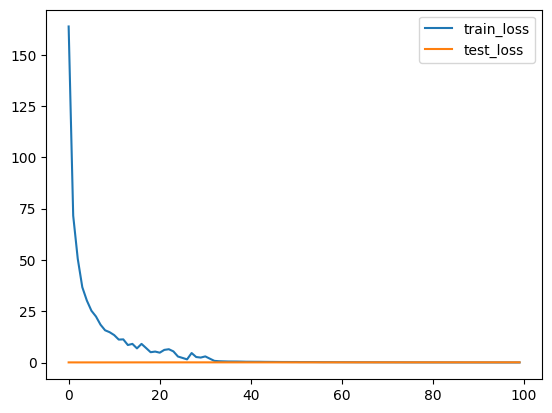

In [12]:
import pandas as pd
results = pd.DataFrame([])
results['train_loss']  = train_record
results['test_loss']  = test_record
results.plot.line(y=['train_loss', 'test_loss'])